In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
engine

Engine(sqlite:///Resources/hawaii.sqlite)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
trip_start = '2017-08-01'
trip_end = '2017-08-07'
tempresult = calc_temps(trip_start,trip_end)[0]
tempresult

(72.0, 79.25, 83.0)

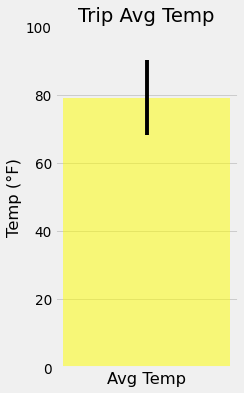

In [12]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

degree_sign = u'\N{DEGREE SIGN}'
tmax = tempresult[2]
tmin = tempresult[0]
y_pos = tempresult[1]  #avg
x_pos = [0]

#bar chart with an error bar
plt.figure(figsize=(3,6), dpi=70)
plt.bar(x_pos, y_pos, yerr=tmax-tmin, color='yellow', alpha=0.5, align='edge')  

plt.xlabel("Avg Temp")
plt.ylabel(f"Temp ({degree_sign}F)")
plt.title("Trip Avg Temp")

#plt.xlim(-0.20)
plt.ylim(0, 100)
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.grid(which='major', axis='x', linestyle='')
#plt.grid(which='major', axis='y', linestyle='-')
plt.show()

### Daily Rainfall Average

In [13]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
precip_query_trip = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= trip_start).\
    filter(Measurement.date <= trip_end).\
    order_by(func.sum(Measurement.prcp).desc()).all()
  
precip_byStn_trip = pd.DataFrame(precip_query_trip, columns=['Station','Name','Latitude','Longitude','Elevation','Prcp_Sum'])
precip_byStn_trip

,Station,Name,Latitude,Longitude,Elevation,Prcp_Sum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.36
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.22
2,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.04
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00


In [14]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [15]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# create as datetime object
dtstart = dt.datetime.strptime(start_date, '%Y-%m-%d')
dtend = dt.datetime.strptime(end_date, '%Y-%m-%d')

# Use the start and end date to create a range of dates
# to include the first date, as start, subtract one day, using Pandas
dtstart_range = dtstart - pd.DateOffset(days=1)
trip_dates = pd.date_range(dtstart_range, dtend).strftime('%Y-%m-%d')[1:].tolist()
trip_dates


['2017-08-01',
 '2017-08-02',
 '2017-08-03',
 '2017-08-04',
 '2017-08-05',
 '2017-08-06',
 '2017-08-07']

In [16]:
# Strip off the year and save a list of strings in the format %m-%d
trip_dates_md = pd.date_range(dtstart_range, dtend).strftime('%m-%d')[1:].tolist()
trip_dates_md

['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']

In [17]:
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
# A list of 'all historic daily normals' for month-day of the trip
normals = [daily_normals(month_day)[0] for month_day in trip_dates_md]
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [18]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals,columns=["tmin","tavg","tmax"],index=trip_dates)
normals_df

,tmin,tavg,tmax
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


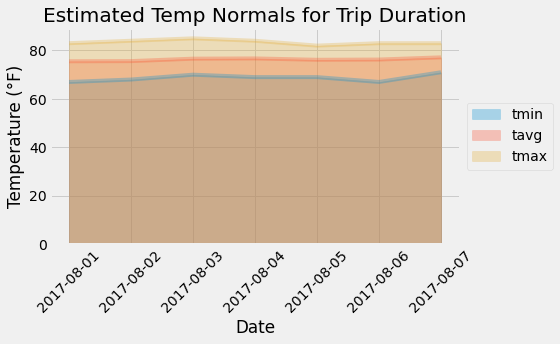

In [19]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind="area",stacked=False,rot=45,alpha=0.3, figsize=(8,5))

plt.xlabel("Date")
plt.ylabel(f"Temperature ({degree_sign}F)")
plt.title('Estimated Temp Normals for Trip Duration')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


## Close Session

In [20]:
session.close()